# Begin Part 1, Neighborhood dataframe

In [7]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [8]:
#! conda install -c anaconda beautifulsoup4
#! conda install -c anaconda lxml

In [9]:
from bs4 import BeautifulSoup
import requests

In [10]:
#get table into a dataframe
html_doc= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html= requests.get(html_doc).text
soup= BeautifulSoup(html,'lxml')
table = soup.find_all('table')[0]
data_list = pd.read_html(str(table))
df=pd.DataFrame(data_list[0])
df.columns = df.iloc[0]
df.drop([0], inplace = True)
df.head()


,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


In [11]:
#Eliminate "Not assigned" bouroughs and replace "not assigned" neighbourhoods with borough name
df=df[df['Borough']!= 'Not assigned']
df.loc[df['Neighbourhood'] == ('Not assigned'), 'Neighbourhood'] = df['Borough']


In [31]:
#Group postcodes together into single entry and list neighbourhoods seperated by a comma
df=df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [41]:
print(df.shape)
print('There are ' + str(df.shape[0]) + ' rows and ' + str(df.shape[1]) + ' columns in this dataframe.')

(103, 3)
There are 103 rows and 3 columns in this dataframe.


# End Part 1, Neighborhood dataframe


# Begin Part 2, Add Latitude and Longitude to dataframe


In [42]:
#Using arcgis gave slightly different coordinates than in the provided csv file and google coordinates
#So I followed the instructions and imported from the csv 
#import geocoder # import geocoder
#lat=[]
#long=[]
#postal_codes=df['Postcode']
#for postal_code in postal_codes:
    # initialize your variable to None
    #lat_lng_coords = None

    # loop until you get the coordinates
    #while(lat_lng_coords is None):
      #g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
      #lat_lng_coords = g.latlng

    #latitude = lat_lng_coords[0]
    #longitude = lat_lng_coords[1]
    #lat.append(latitude)
    #long.append(longitude)
    #print(latitude, longitude)
#df["Latitude"]=lat
#df['Longitude']=long


In [15]:
#import latitude and longitude into dataframe
coord="http://cocl.us/Geospatial_data"
coords=pd.read_csv(coord)
#rename column to match df
coords.rename(columns={"Postal Code": "Postcode"}, inplace=True)
coords
#merge the two dataframes by Postcode
result = pd.merge(df, coords, on='Postcode')
result.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# End Part 2, Add Latitude and Longitude to dataframe


# Begin Part 3, Explore Neighborhoods


In [16]:
# create map of Toronto using latitude and longitude values
latitude=43.645711
longitude=-79.392732
map_Tdot = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Tdot)  
    
map_Tdot

In [17]:
#name variables to use in 4square url
CLIENT_ID = 'O2WP1ZDLIE2MELGB1CCKTMKCQCXTPYB2LUOZKN3EFEV1MOW5' # your Foursquare ID
CLIENT_SECRET = 'RAL1PSZQSDGDJ5S43KIUXZ0YDHXJP05XK0GMXLOUQJ0RTNC0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O2WP1ZDLIE2MELGB1CCKTMKCQCXTPYB2LUOZKN3EFEV1MOW5
CLIENT_SECRET:RAL1PSZQSDGDJ5S43KIUXZ0YDHXJP05XK0GMXLOUQJ0RTNC0


In [18]:
#creat a function to explore venues in a neighborhood and return a dataframe with venue and category
radius = 500
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
#call the function on our neighborhoods using their lats and longs
Tdot_venues = getNearbyVenues(names=result['Neighbourhood'],
                                   latitudes=result['Latitude'],
                                   longitudes=result['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [20]:
#call shape to tell us how many venues there are
print(Tdot_venues.shape)
#determine how many unique venue categories there are
print('There are {} uniques categories.'.format(len(Tdot_venues['Venue Category'].unique())))
Tdot_venues.head()

(2236, 7)
There are 272 uniques categories.


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [44]:
# one hot encoding
Tdot_onehot = pd.get_dummies(Tdot_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Tdot_onehot['Neighbourhood'] = Tdot_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Tdot_onehot.columns[-1]] + list(Tdot_onehot.columns[:-1])
Tdot_onehot = Tdot_onehot[fixed_columns]



In [22]:
Tdot_onehot.head()
Tdot_onehot.shape

(2236, 273)

In [47]:
Tdot_grouped = Tdot_onehot.groupby('Neighbourhood').mean().reset_index()

Tdot_grouped.shape

(99, 273)

In [24]:
#creat a function to return the top venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
#call funciton to find top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Tdot_grouped['Neighbourhood']

for ind in np.arange(Tdot_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tdot_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,American Restaurant,Bakery,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Restaurant
1,Agincourt,Breakfast Spot,Lounge,Skating Rink,Latin American Restaurant,Yoga Studio,Electronics Store,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pharmacy,Beer Store,Fast Food Restaurant,Japanese Restaurant,Sandwich Place,Discount Store,Fried Chicken Joint,Grocery Store,Pizza Place,Empanada Restaurant
4,"Alderwood, Long Branch",Pizza Place,Pharmacy,Pub,Gym,Skating Rink,Dance Studio,Coffee Shop,Sandwich Place,Pool,Athletics & Sports


### the 2 cells below I try to use the elbow method to determine the optimal number of cluster to use. However, there was no "elbow"  in the graph so I end up using k=5 like in the previous lab.

In [48]:
Tdot_grouped_clustering = Tdot_grouped.drop('Neighbourhood', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Tdot_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

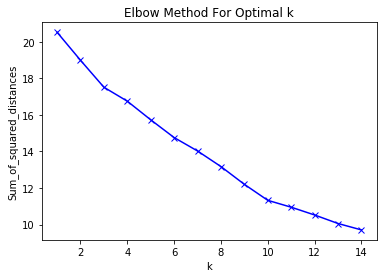

In [49]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [28]:
# set number of clusters
kclusters = 5

Tdot_grouped_clustering = Tdot_grouped.drop('Neighbourhood', 1)

# run k-means clustering fit
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tdot_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [51]:
# add clustering labels
#neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Tdot_merged = result

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Tdot_merged = Tdot_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='right')


Tdot_merged.sort_values(by=['Cluster Labels'])

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
71,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Accessories Store,Sporting Goods Shop,Boutique,Miscellaneous Shop,Coffee Shop,Gift Shop,Vietnamese Restaurant,Event Space
70,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0,Coffee Shop,Café,Hotel,Steakhouse,Restaurant,Gastropub,Bakery,Bar,American Restaurant,Seafood Restaurant
69,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,0,Coffee Shop,Restaurant,Café,Seafood Restaurant,Italian Restaurant,Beer Bar,Bakery,Hotel,Japanese Restaurant,Breakfast Spot
68,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,0,Airport Service,Airport Lounge,Harbor / Marina,Airport Terminal,Coffee Shop,Sculpture Garden,Boat or Ferry,Bar,Boutique,Airport Food Court
67,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,0,Café,Vietnamese Restaurant,Bar,Coffee Shop,Dumpling Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Mexican Restaurant,Bakery,Farmers Market
66,M5S,Downtown Toronto,"Harbord, University of Toronto",43.662696,-79.400049,0,Café,Bar,Italian Restaurant,Japanese Restaurant,Bookstore,Sandwich Place,Restaurant,Bakery,Yoga Studio,Pub
65,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0,Café,Sandwich Place,Coffee Shop,Vegetarian / Vegan Restaurant,Indian Restaurant,BBQ Joint,Pub,Burger Joint,American Restaurant,Liquor Store
63,M5N,Central Toronto,Roselawn,43.711695,-79.416936,0,Garden,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio,Filipino Restaurant
62,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,0,Coffee Shop,Italian Restaurant,Greek Restaurant,Thai Restaurant,Grocery Store,Pharmacy,Pizza Place,Pub,Restaurant,Café


In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
Tdot_merged['Cluster Labels']= Tdot_merged['Cluster Labels'].astype(int)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tdot_merged['Latitude'], Tdot_merged['Longitude'], Tdot_merged['Neighbourhood'], Tdot_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# End Part 3, Explore Neighborhoods
